<a href="https://colab.research.google.com/github/Vincent-Kwan/Safe-Roads-Competition/blob/master/Pedestrian_Stupidity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

from pathlib import Path
import math
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neural_network import MLPClassifier
import matplotlib.pylab as plt
!pip install dmba
from dmba import plotDecisionTree, classificationSummary, regressionSummary, adjusted_r2_score, AIC_score, forward_selection, backward_elimination
!pip install scikit-plot
import scikitplot as skplt

     |████████████████████████████████| 11.8 MB 6.3 MB/s 
no display found. Using non-interactive Agg backend


In [2]:
fixed_url = 'https://raw.githubusercontent.com/Vincent-Kwan/Safe-Roads-Competition/master/Data/Created%20datasets/Pedestrian_Feature_Count.csv'

In [3]:
pedestrians = pd.read_csv(fixed_url)
pedestrians.head()

,Unnamed: 0,LATITUDE,LONGITUDE,PEDTYPE,PEDACT,PEDCOND,TRAFFCTL,LIGHT,VISIBILITY,RDSFCOND,TIME,COUNT
0,0,43.594,-79.533,Vehicle is going straight thru inter.while ped...,Crossing marked crosswalk without ROW,Inattentive,Traffic Signal,Daylight,Clear,Dry,1367.000000,2
1,1,43.594,-79.533,Vehicle turns left while ped crosses with ROW ...,Crossing with right of way,Normal,Traffic Signal,Dusk,Clear,Dry,1367.000000,2
2,2,43.595,-79.528,<Null>,Other,Other,No Control,"Dark, artificial",Clear,Dry,1949.000000,1
3,3,43.597,-79.522,Vehicle is reversing and hits pedestrian,Other,Normal,No Control,Daylight,Clear,Dry,600.000000,1
4,4,43.598,-79.516,Vehicle is going straight thru inter.while ped...,Running onto Roadway,Normal,Traffic Signal,Dark,Rain,Wet,1956.333333,2


In [4]:
pedestrians = pedestrians.replace('Yes', 1).replace('<Null>', 0).replace('<Null', 0)

In [5]:
outcome = 'COUNT'
predictors = ['PEDTYPE', 'PEDCOND', 'PEDACT', 'TRAFFCTL', 'LIGHT', 'VISIBILITY', 'RDSFCOND']
x = pd.get_dummies(pedestrians[predictors], drop_first = True)
y = pedestrians[outcome]

train_x, valid_x, train_y, valid_y = train_test_split(x, y, test_size=0.4, random_state=1)

In [6]:
reg = LinearRegression()
reg.fit(train_x, train_y)

LinearRegression()

In [7]:
reg.coef_

array([ 5.57185696e-01,  7.07709204e-01,  3.97246356e-01,  1.00352152e+00,
        5.60605770e-01,  4.18561395e-01,  5.43958952e-01,  3.17177331e-01,
        2.48949250e-01,  2.72236045e-01,  3.61424503e-01,  3.59147525e-01,
        1.25773299e-01,  5.94439511e-01,  6.03533307e-02,  4.92414773e-01,
       -1.85665010e-01,  4.91449683e-01,  1.34557809e-01,  2.09250669e-01,
        7.53158862e-02,  2.53639434e-02,  1.03715214e-01,  1.56167463e-02,
       -1.25577662e-02,  1.52259052e-01, -7.39097862e-01, -3.06066354e-01,
       -5.12949354e-01, -6.39302037e-01, -1.04791779e+00, -5.41908621e-01,
       -5.76136851e-01, -5.18910853e-01, -1.07470906e+00, -4.96767030e-01,
       -6.63422978e-01, -7.91323182e-01, -5.13422940e-01, -1.09088137e+00,
       -4.06462329e-01, -1.98495416e+00, -1.84348403e+00, -2.22044605e-16,
       -2.11316744e+00, -2.07371361e+00, -2.39316977e+00, -2.00857711e+00,
       -2.67526065e+00, -1.32874064e+00, -1.22688684e+00,  5.55548086e-02,
        6.09115422e-01, -

In [8]:
regressionSummary(train_y, reg.predict(train_x))
regressionSummary(valid_y, reg.predict(valid_x))


Regression statistics

                      Mean Error (ME) : -0.0000
       Root Mean Squared Error (RMSE) : 0.9085
            Mean Absolute Error (MAE) : 0.6379
          Mean Percentage Error (MPE) : -21.1427
Mean Absolute Percentage Error (MAPE) : 42.0555

Regression statistics

                      Mean Error (ME) : 0.0463
       Root Mean Squared Error (RMSE) : 1.0120
            Mean Absolute Error (MAE) : 0.7099
          Mean Percentage Error (MPE) : -20.7852
Mean Absolute Percentage Error (MAPE) : 44.6396


In [9]:
adjusted_r2_score(valid_y, reg.predict(valid_x), reg)

-0.025153448363811393

In [10]:
pedestrians.skew(axis = 1, skipna = True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


0       2.206559
1       2.206473
2       2.221464
3       2.086024
4       2.221442
          ...   
2543    1.209832
2544    1.210354
2545    1.823324
2546    0.686698
2547    0.655795
Length: 2548, dtype: float64

In [11]:
pred_error_train = pd.DataFrame({ 
 'residual': train_y - reg.predict(train_x), 
 'data set': 'training' 
}) 

In [12]:
pred_error_train.skew()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


residual    2.313335
dtype: float64

In [13]:
!pip install shap
import shap

     |████████████████████████████████| 564 kB 8.4 MB/s 


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

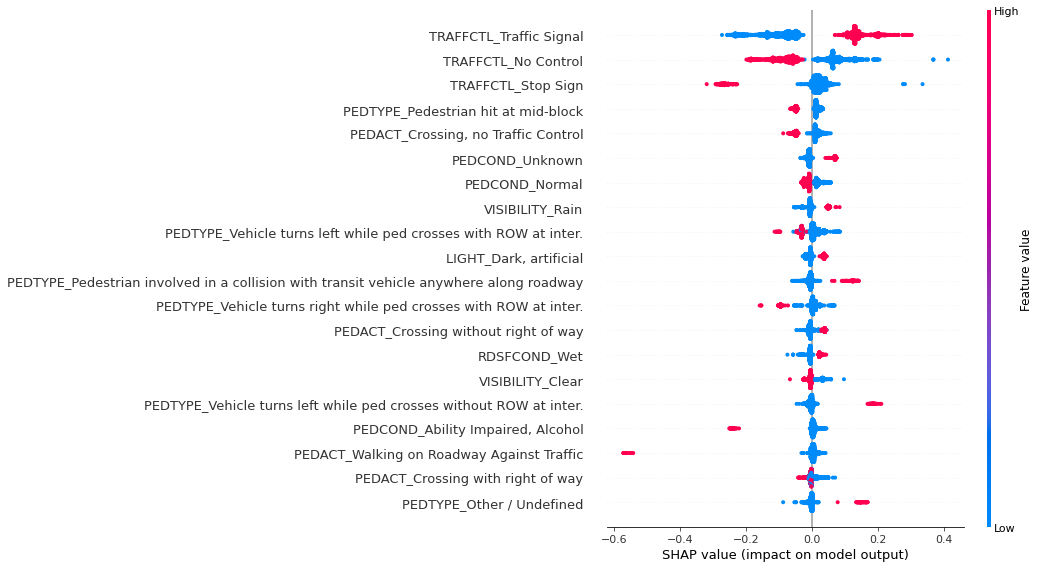

In [ ]:
explainer = shap.Explainer(reg, masker=shap.maskers.Impute(data= train_x),
                           feature_names= train_x.columns, algorithm="linear")
shap_values = explainer.shap_values(x)
shap.summary_plot(shap_values, x)

In [ ]:
pd.DataFrame({'Actual': valid_y, 'Predicted': reg.predict(valid_x)})

,Actual,Predicted
81,1,1.436495
107,1,2.035080
1297,1,1.292468
2264,1,1.408960
645,1,1.399686
...,...,...
1385,1,1.719007
11,1,1.344652
210,1,1.365550
2124,2,1.399213


(0.6499999999999999, 8.35, 0.32031266774312384, 3.540477338826396)

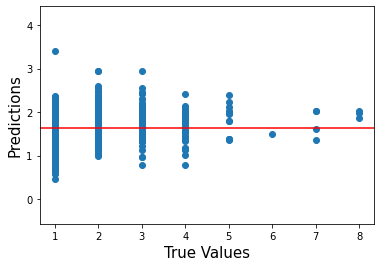

In [ ]:
predicted_value = reg.predict(valid_x)
plt.scatter(valid_y, reg.predict(valid_x))
plt.axhline(y = y.mean(), color = 'r', linestyle = '-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')

In [ ]:
def train_model(variables):
    if len(variables) == 0:
        return None
    model = LinearRegression()
    model.fit(train_x[variables], train_y)
    return model

def score_model(model, variables):
    if len(variables) == 0:
        return AIC_score(train_y, [train_y.mean()] * len(train_y), model, df=1)
    return AIC_score(train_y, model.predict(train_x[variables]), model)

best_model, best_variables = forward_selection(train_x.columns, train_model, score_model, verbose=True)

print(best_variables)

Variables: PEDTYPE_Other / Undefined, PEDTYPE_Pedestrian hit a PXO/ped. Mid-block signal, PEDTYPE_Pedestrian hit at mid-block, PEDTYPE_Pedestrian hit at parking lot, PEDTYPE_Pedestrian hit at private driveway, PEDTYPE_Pedestrian hit on sidewalk or shoulder, PEDTYPE_Pedestrian involved in a collision with transit vehicle anywhere along roadway, PEDTYPE_Unknown, PEDTYPE_Vehicle hits the pedestrian walking or running out from between parked vehicles at mid-block, PEDTYPE_Vehicle is going straight thru inter.while ped cross with ROW, PEDTYPE_Vehicle is going straight thru inter.while ped cross without ROW, PEDTYPE_Vehicle is reversing and hits pedestrian, PEDTYPE_Vehicle turns left while ped crosses with ROW at inter., PEDTYPE_Vehicle turns left while ped crosses without ROW at inter., PEDTYPE_Vehicle turns right while ped crosses with ROW at inter., PEDTYPE_Vehicle turns right while ped crosses without ROW at inter., PEDCOND_Ability Impaired, Alcohol, PEDCOND_Ability Impaired, Alcohol Ove

In [ ]:
regressionSummary(valid_y, best_model.predict(valid_x[best_variables]))


Regression statistics

                      Mean Error (ME) : 0.0491
       Root Mean Squared Error (RMSE) : 1.0087
            Mean Absolute Error (MAE) : 0.7064
          Mean Percentage Error (MPE) : -20.9395
Mean Absolute Percentage Error (MAPE) : 44.4824


In [14]:
clf = MLPClassifier(activation = 'logistic', solver='lbfgs', hidden_layer_sizes=3, random_state=1, max_iter=5000)
clf.fit(train_x, train_y)

MLPClassifier(activation='logistic', hidden_layer_sizes=3, max_iter=5000,
              random_state=1, solver='lbfgs')

In [15]:
clf.predict(train_x)

array([1, 1, 1, ..., 1, 1, 2])

In [16]:
classificationSummary(train_y, clf.predict(train_x))
classificationSummary(valid_y, clf.predict(valid_x))

Confusion Matrix (Accuracy 0.6446)

       Prediction
Actual   0   1   2   3   4   5   6
     0 903  33   0   0   0   0   0
     1 285  82   0   0   0   0   0
     2 151  10   0   0   0   0   0
     3  34   5   0   0   0   0   0
     4  14   2   0   0   0   0   0
     5   4   0   0   0   0   0   0
     6   5   0   0   0   0   0   0
Confusion Matrix (Accuracy 0.5804)

       Prediction
Actual   0   1   2   3   4   5   6   7
     0 566  57   0   0   0   0   0   0
     1 204  26   0   0   0   0   0   0
     2  96  10   0   0   0   0   0   0
     3  35   6   0   0   0   0   0   0
     4  12   0   0   0   0   0   0   0
     5   1   0   0   0   0   0   0   0
     6   4   0   0   0   0   0   0   0
     7   3   0   0   0   0   0   0   0


In [ ]:
explainer = shap.Explainer(clf, masker=shap.maskers.Impute(data= train_x),
                           feature_names= train_x.columns, algorithm="linear")
shap_values = explainer.shap_values(train_x)
shap.summary_plot(shap_values, train_x)

Exception: ignored

In [ ]:
pedestrians['PEDACT'].unique()

array(['Crossing marked crosswalk without ROW',
       'Crossing with right of way', 'Other', 'Running onto Roadway',
       'Pushing/Working on Vehicle', 'Crossing, no Traffic Control',
       'Crossing without right of way', '<Null>',
       'Walking on Roadway Against Traffic', 'On Sidewalk or Shoulder',
       'Walking on Roadway with Traffic',
       'Coming From Behind Parked Vehicle',
       'Person Getting on/off Vehicle', 'Crossing, Pedestrian Crossover',
       'Playing or Working on Highway',
       'Person Getting on/off School Bus'], dtype=object)

In [ ]:
pedestrians = pedestrians.replace('Crossing marked crosswalk without ROW', 1).replace('Running onto Roadway', 1).replace('Crossing, no Traffic Control', 1).replace(
    'Crossing without right of way', 1).replace('Walking on Roadway Against Traffic', 1).replace('Walking on Roadway with Traffic', 1).replace('Playing or Working on Highway', 1)

In [ ]:
pedestrians = pedestrians.replace('Crossing with right of way', 0).replace('Pushing/Working on Vehicle', 0).replace('On Sidewalk or Shoulder', 0).replace(
    'Coming From Behind Parked Vehicle', 0).replace('Person Getting on/off Vehicle', 0).replace('Crossing, Pedestrian Crossover', 0).replace('Person Getting on/off School Bus', 0).replace('Other', 0)

In [ ]:
pedestrians.head()

,Unnamed: 0,LATITUDE,LONGITUDE,PEDTYPE,PEDACT,PEDCOND,TRAFFCTL,LIGHT,VISIBILITY,RDSFCOND,TIME
0,0,43.594,-79.533,Vehicle is going straight thru inter.while ped...,1,Inattentive,Traffic Signal,Daylight,Clear,Dry,1367.000000
1,1,43.594,-79.533,Vehicle turns left while ped crosses with ROW ...,0,Normal,Traffic Signal,Dusk,Clear,Dry,1367.000000
2,2,43.595,-79.528,0,0,0,No Control,"Dark, artificial",Clear,Dry,1949.000000
3,3,43.597,-79.522,Vehicle is reversing and hits pedestrian,0,Normal,No Control,Daylight,Clear,Dry,600.000000
4,4,43.598,-79.516,Vehicle is going straight thru inter.while ped...,1,Normal,Traffic Signal,Dark,Rain,Wet,1956.333333


In [ ]:
predictors = ['PEDCOND', 'TRAFFCTL', 'LIGHT', 'VISIBILITY', 'RDSFCOND']
outcome = 'PEDACT'

x = pd.get_dummies(pedestrians[predictors])
y = pedestrians[outcome]

train_x, valid_x, train_y, valid_y = train_test_split(x, y, test_size=0.4, random_state=1)

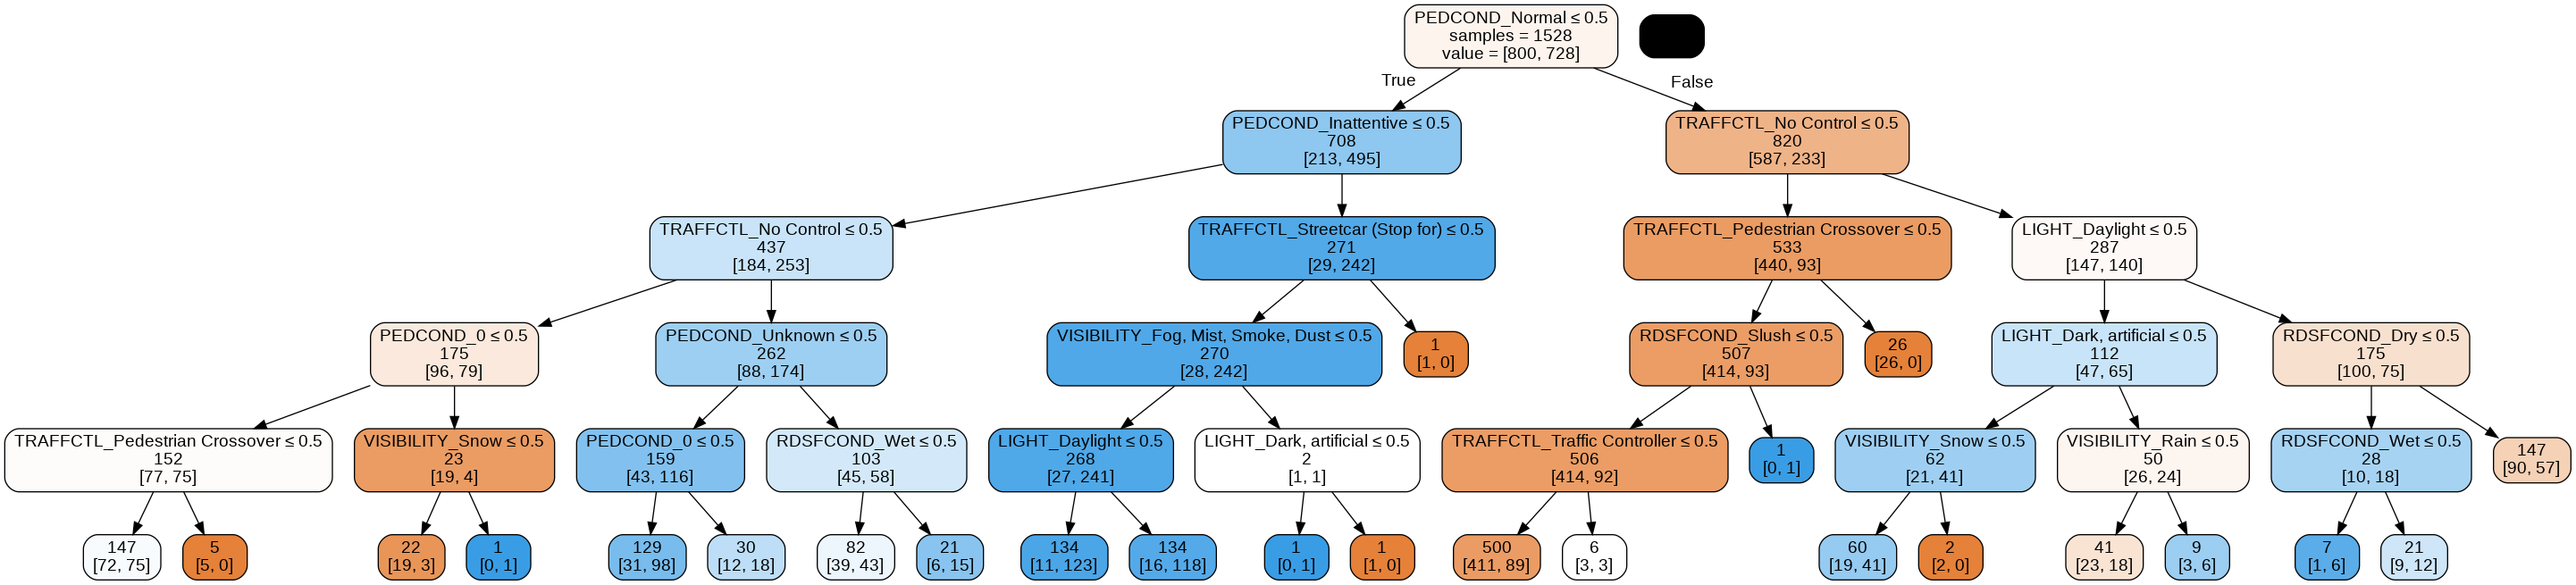

In [ ]:
smallClassTree = DecisionTreeClassifier(max_depth=5, random_state=1)
smallClassTree.fit(train_x,train_y)
plotDecisionTree(smallClassTree, feature_names=train_x.columns)

In [ ]:
classificationSummary(valid_y,smallClassTree.predict(valid_x))

Confusion Matrix (Accuracy 0.7402)

       Prediction
Actual   0   1
     0 416 121
     1 144 339


In [ ]:
param_grid = { 
 'max_depth': [3, 2, 4, 5, 6, 7, 8,10, 11, 12, 13, 14, 15], 
 'min_impurity_decrease': [0.05, 0.02, 0.01, 0.001], 
 'min_samples_split': [0.1, 0.07, 0.05, 0.01, 0.005] 
} 

In [ ]:
gridsearch = GridSearchCV(DecisionTreeRegressor(random_state=1), param_grid, cv=5, n_jobs=-1)
gridsearch.fit(train_x, train_y)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [3, 2, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14,
                                       15],
                         'min_impurity_decrease': [0.05, 0.02, 0.01, 0.001],
                         'min_samples_split': [0.1, 0.07, 0.05, 0.01, 0.005]})

In [ ]:
regtree = gridsearch.best_estimator_

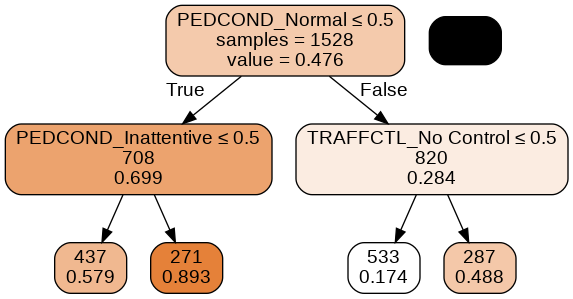

In [ ]:
plotDecisionTree(regtree, feature_names=train_x.columns)

In [ ]:
regressionSummary(valid_y, regtree.predict(valid_x))


Regression statistics

               Mean Error (ME) : -0.0027
Root Mean Squared Error (RMSE) : 0.4170
     Mean Absolute Error (MAE) : 0.3582


In [ ]:
rf = RandomForestClassifier(random_state=1, n_estimators=500)
rf.fit(train_x, train_y)

RandomForestClassifier(n_estimators=500, random_state=1)

In [ ]:
importance = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

In [ ]:
df = pd.DataFrame({'feature': train_x.columns,
                   'importance': importance,
                   'std': std})
print(df.sort_values('importance', ascending=False))

                                       feature  importance       std
5                          PEDCOND_Inattentive    0.209277  0.107407
7                               PEDCOND_Normal    0.203698  0.127846
9                          TRAFFCTL_No Control    0.118313  0.070668
17                     TRAFFCTL_Traffic Signal    0.064651  0.050692
8                              PEDCOND_Unknown    0.040481  0.020765
23                              LIGHT_Daylight    0.034316  0.014553
4                    PEDCOND_Had Been Drinking    0.033131  0.018155
19                                  LIGHT_Dark    0.028288  0.012558
34                                RDSFCOND_Dry    0.023847  0.011386
40                                RDSFCOND_Wet    0.023085  0.010961
20                      LIGHT_Dark, artificial    0.022714  0.010398
10               TRAFFCTL_Pedestrian Crossover    0.019887  0.014843
27                            VISIBILITY_Clear    0.019736  0.009253
0            PEDCOND_Ability Impai